In [1]:
# 📌 STEP 1: Upload ZIP file
from google.colab import files
uploaded = files.upload()


Saving user-wallet-transactions.json.zip to user-wallet-transactions.json.zip


In [2]:
# 📌 STEP 2: Extract and Read JSON
import zipfile
import json
import pandas as pd
from datetime import datetime

# Extract the uploaded ZIP
zip_filename = list(uploaded.keys())[0]
extract_path = "./unzipped_data"

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Find the JSON file inside
import os
for file in os.listdir(extract_path):
    if file.endswith(".json"):
        json_path = os.path.join(extract_path, file)
        break

# Load JSON data
with open(json_path, 'r') as f:
    data = json.load(f)


In [3]:
# 📌 STEP 3: Parse JSON into DataFrame
def parse_transaction(tx):
    user = tx['userWallet']
    action = tx['action'].lower()
    timestamp = tx['timestamp']
    try:
        amount = float(tx['actionData'].get('amount', 0))
    except:
        amount = 0
    try:
        price = float(tx['actionData'].get('assetPriceUSD', 1))
    except:
        price = 1
    amount_usd = amount * price
    asset = tx['actionData'].get('assetSymbol', '')

    return {
        'userWallet': user,
        'action': action,
        'timestamp': datetime.utcfromtimestamp(timestamp),
        'amount_usd': amount_usd,
        'assetSymbol': asset
    }

parsed_data = [parse_transaction(tx) for tx in data]
tx_df = pd.DataFrame(parsed_data)
tx_df.head()


,userWallet,action,timestamp,amount_usd,assetSymbol
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,2021-08-17 05:29:26,1.987664e+09,USDC
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,2021-05-20 15:36:53,2.856945e+20,WMATIC
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-24 09:28:33,9.223773e+14,WMATIC
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-31 23:15:18,4.229933e+15,WMATIC
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,2021-04-19 15:25:07,5.026161e+05,USDC


In [4]:
# 📌 STEP 4: Feature Extraction Per Wallet
group = tx_df.groupby("userWallet")

def extract_features(wallet_df):
    features = {}
    actions = wallet_df['action'].value_counts().to_dict()
    total_tx = len(wallet_df)

    features['total_transactions'] = total_tx
    features['num_deposits'] = actions.get('deposit', 0)
    features['num_borrows'] = actions.get('borrow', 0)
    features['num_repays'] = actions.get('repay', 0)
    features['num_redeems'] = actions.get('redeemunderlying', 0)
    features['num_liquidations'] = actions.get('liquidationcall', 0)

    features['total_deposit_usd'] = wallet_df[wallet_df['action'] == 'deposit']['amount_usd'].sum()
    features['total_borrow_usd'] = wallet_df[wallet_df['action'] == 'borrow']['amount_usd'].sum()
    features['total_repay_usd'] = wallet_df[wallet_df['action'] == 'repay']['amount_usd'].sum()

    features['avg_deposit_usd'] = wallet_df[wallet_df['action'] == 'deposit']['amount_usd'].mean() or 0
    features['avg_borrow_usd'] = wallet_df[wallet_df['action'] == 'borrow']['amount_usd'].mean() or 0

    borrow_amt = features['total_borrow_usd']
    repay_amt = features['total_repay_usd']
    features['repay_to_borrow_ratio'] = repay_amt / borrow_amt if borrow_amt > 0 else 0

    features['unique_assets_used'] = wallet_df['assetSymbol'].nunique()
    features['unique_actions_used'] = wallet_df['action'].nunique()

    timestamps = wallet_df['timestamp']
    if not timestamps.empty:
        features['tx_activity_span_days'] = (timestamps.max() - timestamps.min()).days
    else:
        features['tx_activity_span_days'] = 0

    return pd.Series(features)

wallet_features = group.apply(extract_features).reset_index()
wallet_features.head()

# Add a basic credit score (0-1000 scale)
def score_wallet(row):
    score = 300
    score += row['repay_to_borrow_ratio'] * 300  # up to 300 points
    score += row['unique_actions_used'] * 20     # up to 100
    score += row['tx_activity_span_days'] * 2    # up to 100
    score -= row['num_liquidations'] * 50        # penalize
    return min(1000, max(0, int(score)))

wallet_features['credit_score'] = wallet_features.apply(score_wallet, axis=1)



/tmp/ipython-input-4-753815097.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wallet_features = group.apply(extract_features).reset_index()


In [5]:
# 📌 STEP 5: Save to CSV for analysis or model input
wallet_features.to_csv("wallet_features.csv", index=False)
files.download("wallet_features.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ML Model & Credit Scoring


In [6]:
# 📌 STEP 1: Import Required Libraries
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 📌 STEP 2: Load wallet features
wallet_df = pd.read_csv("wallet_features.csv")

# 📌 STEP 3: Prepare Data for Modeling
# Drop wallet ID for training
X = wallet_df.drop(columns=["userWallet"])

# Fill NaNs (e.g., due to missing repays or borrows)
X.fillna(0, inplace=True)

# Optional: Scale features for uniformity
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
# 📌 STEP 4: Train Isolation Forest (Unsupervised Anomaly Detection)
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(X_scaled)

# Predict anomaly scores
anomaly_score = model.decision_function(X_scaled)  # higher is better


In [8]:
# 📌 STEP 5: Convert Anomaly Score → Credit Score (0–1000)
# Normalize to 0–1000 range
min_score = anomaly_score.min()
max_score = anomaly_score.max()

# Scale and reverse (high score = good, anomaly = bad)
credit_score = 1000 * (anomaly_score - min_score) / (max_score - min_score)
credit_score = credit_score.round(0).astype(int)


In [9]:
# 📌 STEP 6: Save Final Output
wallet_df['credit_score'] = credit_score
wallet_df[['userWallet', 'credit_score'] + [col for col in wallet_df.columns if col not in ['userWallet', 'credit_score']]].to_csv("wallet_scores.csv", index=False)

# Download CSV
from google.colab import files
files.download("wallet_scores.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Code to Generate Histogram

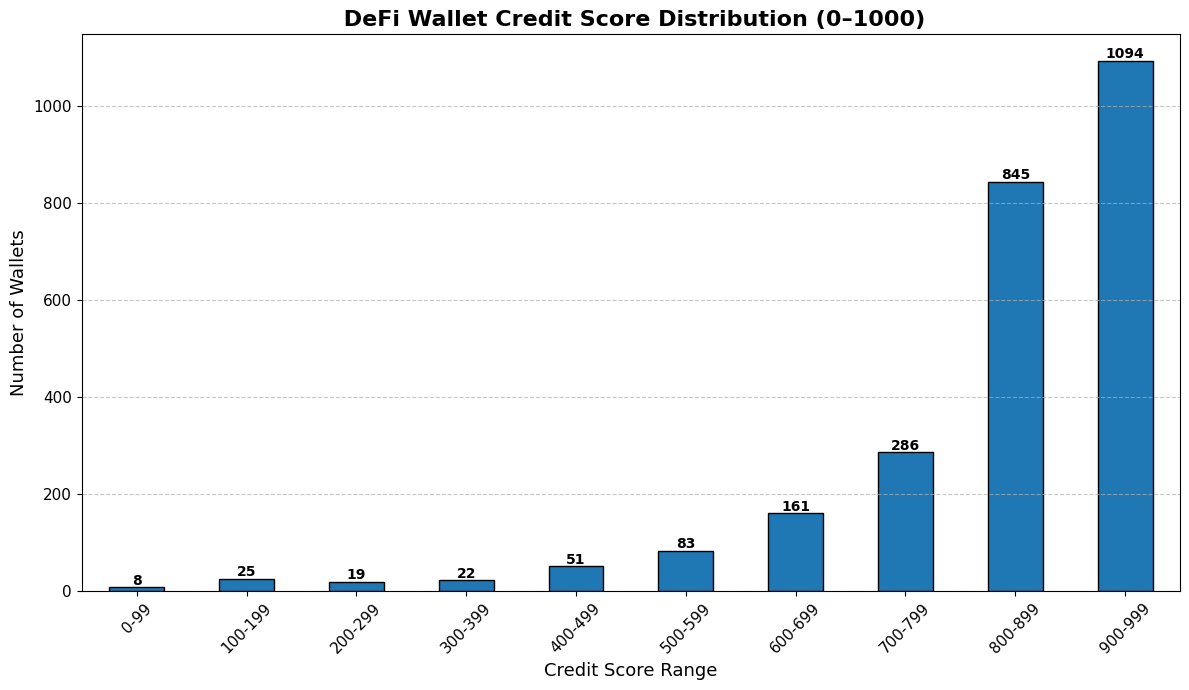

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("wallet_scores.csv")

# Score bins
bins = list(range(0, 1001, 100))
labels = [f"{i}-{i+99}" for i in bins[:-1]]
df['score_range'] = pd.cut(df['credit_score'], bins=bins, right=False, labels=labels)

# Count per bucket
counts = df['score_range'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 7))
bars = counts.plot(kind='bar', color='#1f77b4', edgecolor='black')

# Annotations
for i, val in enumerate(counts):
    plt.text(i, val + 5, str(val), ha='center', fontsize=10, fontweight='bold')

plt.title(" DeFi Wallet Credit Score Distribution (0–1000)", fontsize=16, weight='bold')
plt.xlabel("Credit Score Range", fontsize=13)
plt.ylabel("Number of Wallets", fontsize=13)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save
plt.savefig("score_distribution.png")
plt.show()
